In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from nwnTorch.jn_models import *
from nwnTorch.nwn import *
from nwnTorch.generate_adj import *
from nwnTorch.misc import *

In [4]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
con = pkl_load("/home/rzhu/data_access/l2l_data/volterra_data/con0.pkl")
adj = torch.tensor(con["adj_matrix"])
# net = NWN(adj, "sydney")

In [8]:

lambda_dict = pkl_load("/home/rzhu/data_access/l2l_data/volterra_data/lambda_data.pkl")

In [9]:
maxG   = lambda_dict["maxG"]
minG   = lambda_dict["minG"]
netG   = lambda_dict["netG"]
readL0 = lambda_dict["lambda"]

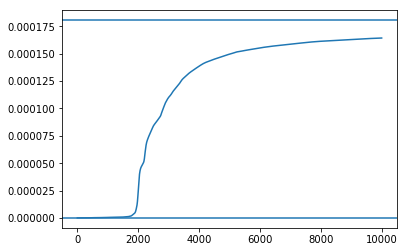

In [10]:
plt.axhline(maxG)
plt.plot(netG)
plt.axhline(minG)

In [22]:
net                     = NWN(adj, "sydney")
E                       = net.number_of_junctions
N                       = net.number_of_nodes
net.params["Ron"]       = 1e4
net.params["grow"]      = 5
net.params["decay"]     = 10
net.params["precision"] = True
net.params["collapse"]  = True
net.params["dt"]        = 1e-3

T0                   = 2000
electrodes           = lambda_dict["electodes"]
net.junction_state.L = readL0[T0]
net.junction_state.updateG()

Tmax  = 2
onAmp = 1.55
# onAmp = 0.05
# b     = 0.2001
b     = 0.0001
# onAmp = 10
f     = 2
T     = torch.arange(0,Tmax,1e-3)
T_l   = len(T)
# sig   = onAmp*torch.sin(2*torch.pi*f*T)
sig   = generate_signal("Triangular", onAmp, f, Tmax) + b

readI = torch.zeros(T_l, 1)
readG = torch.zeros(T_l, E)
readL = torch.zeros(T_l, E)
readV = torch.zeros(T_l, N)
netG2 = torch.zeros(T_l)

for t in tqdm(range(T_l)):
    sig_in = torch.zeros(len(electrodes))
    sig_in[0] = sig[t]

    net.sim(sig_in.reshape(1,-1), electrodes)
    readI[t,:] = net.I[-1:]
    # readG[t,:] = net.test_conductance(electrodes)
    readG[t,:] = net.junction_state.G[:]
    readL[t,:] = net.junction_state.L[:]
    readV[t,:] = net.V
    netG2[t] = net.I[-1] / sig[t]

100%|██████████| 2000/2000 [01:48<00:00, 18.42it/s]


In [23]:
net_norm  = minG 
indi_norm = 1/net.params["Roff"]

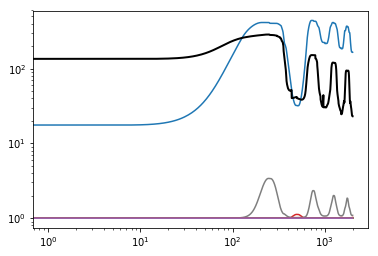

In [24]:

plt.plot(readG[:,np.random.randint(0,5000,25)]/ indi_norm)

plt.plot(netG2 / net_norm, lw = 2, c  = "k")

plt.xscale("log")
plt.yscale("log")

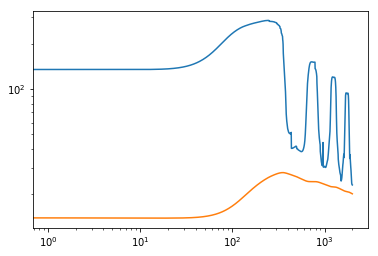

In [25]:
EA = netG2 / net_norm
TA = (torch.cumsum(readG /indi_norm, axis = 0) / torch.arange(1,T_l+1).reshape(T_l,-1)).mean(axis = 1)

plt.plot(EA)
# plt.twinx()
plt.plot(TA)

plt.xscale("log")
plt.yscale("log")

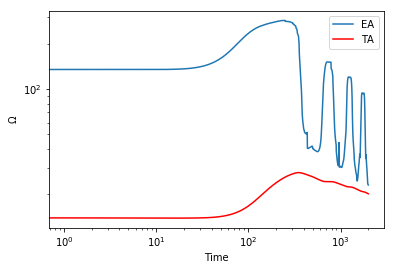

In [26]:
EA = netG2 / net_norm
# EA = readG.mean(axis = 1) / indi_norm
TA = (torch.cumsum(readG/indi_norm, axis = 0) / torch.arange(1,T_l+1).reshape(T_l,-1)).mean(axis = 1)

# EA_norm = EA / EA.max()
# TA_norm = TA / TA.max()

# EA_norm = EA / (max(EA) - min(EA))
# TA_norm = TA / (max(TA) - min(TA))

# EA_norm = EA / EA[0]
# TA_norm = TA / TA[0]

# EA_norm = (EA-(EA).min())/ (max(EA) - min(EA))
# TA_norm = (TA-(TA).min())/ (max(TA) - min(TA))

plt.plot(EA, label = "EA")
# plt.twinx()
plt.plot(TA, c = "r", label = "TA")

plt.xscale("log")
plt.yscale("log")

plt.xlabel("Time")
plt.ylabel(r"$\Omega$")
plt.legend()

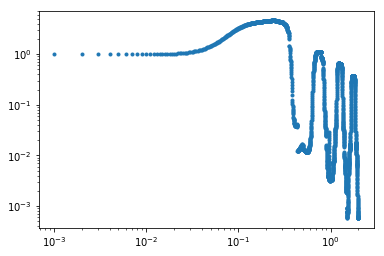

In [27]:
omegaTM = (TA - EA)**2
rate = omegaTM/omegaTM[1]
plt.plot(T, rate, marker = '.', ls = "none")

plt.yscale("log")
plt.xscale("log")

In [28]:
torch.manual_seed(0)
elec_out = torch.randint(N, (1,100))

In [29]:
target = generate_signal("Square", onAmp, f, Tmax) + b
lhs = readV[:,elec_out.reshape(-1)]
# lhs = torch.hstack((torch.ones(T_l,1), readV[:,elec_out.reshape(-1)]))
# lhs = torch.hstack((sig.reshape(-1,1), readV[:,elec_out.reshape(-1)]))
rhs = target 

# weight  = torch.linalg.lstsq(lhs, rhs, rcond=None).solution
weight, _, rcond = best_regress(lhs, rhs)
predict =  weight @ lhs.T
result  = get_MSE(predict, rhs)
print(rcond)
print(get_MSE(predict, rhs))
print(get_RNMSE(predict, rhs))

tensor(-4)
tensor(0.1914)
tensor(0.2825)


Text(0.5, 1.0, 'RNMSE =  0.283')

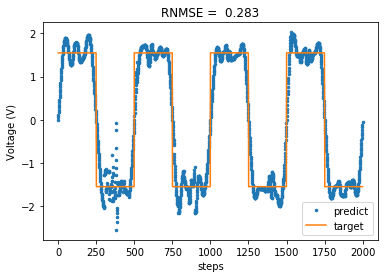

In [30]:
plt.plot(predict, ".", label = "predict", ms = 5)
plt.plot(target, label = "target")

plt.xlabel("steps")
plt.ylabel("Voltage (V)")
plt.legend()
plt.title(f"RNMSE = {get_RNMSE(predict, rhs) : .3}")

Text(0, 0.5, 'collective conductance (S)')

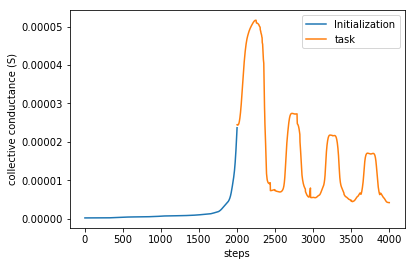

In [31]:
plt.plot(netG[:T0], label = "Initialization")
plt.plot(range(T0, T0 + T_l), netG2, label = "task")
plt.legend()

plt.xlabel("steps")
plt.ylabel("collective conductance (S)")

Text(0, 0.5, 'collective conductance (S)')

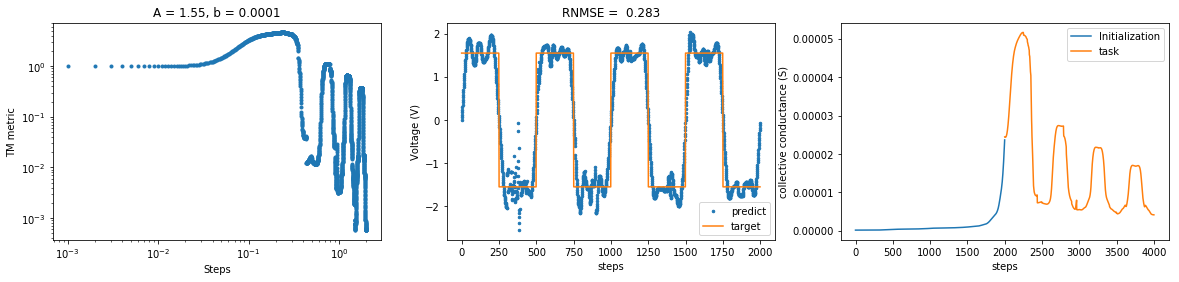

In [32]:
fig, axes = plt.subplots(1,3, figsize = (20, 4))

axes[0].plot(T, rate, marker = '.', ls = "none")
axes[0].set_yscale("log")
axes[0].set_xscale("log")
axes[0].set_xlabel("Steps")
axes[0].set_ylabel("TM metric")
axes[0].set_title(f"A = {onAmp}, b = {b}")


axes[1].plot(predict, ".", label = "predict", ms = 5)
axes[1].plot(target, label = "target")
axes[1].set_xlabel("steps")
axes[1].set_ylabel("Voltage (V)")
axes[1].legend()
axes[1].set_title(f"RNMSE = {get_RNMSE(predict, rhs) : .3}")

axes[2].plot(netG[:T0], label = "Initialization")
axes[2].plot(range(T0, T0 + T_l), netG2, label = "task")
axes[2].legend()

axes[2].set_xlabel("steps")
axes[2].set_ylabel("collective conductance (S)")